## MMD ResNet for RNA data - Z-scored

Use GTEX as source and TCGA as target since there are 2445 GTEX samples and only 683 TCGA samples

### Imports

In [1]:
import os.path
import keras.optimizers
from Calibration_Util import DataHandler as dh 
from Calibration_Util import FileIO as io
from keras.layers import Input, Dense, merge, Activation, add
from keras.models import Model
from keras import callbacks as cb
import numpy as np
import matplotlib
from keras.layers.normalization import BatchNormalization
#detect display
import os
havedisplay = "DISPLAY" in os.environ
#if we have a display use a plotting backend
if havedisplay:
    matplotlib.use('TkAgg')
else:
    matplotlib.use('Agg')

import CostFunctions as cf
import Monitoring as mn
from keras.regularizers import l2
from sklearn import decomposition
from keras.callbacks import LearningRateScheduler
import math
import ScatterHist as sh
from keras import initializers
from numpy import genfromtxt
import sklearn.preprocessing as prep
import tensorflow as tf
import keras.backend as K

import pandas as pd

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Configure hyperparameters

In [2]:
mmdNetLayerSizes = [20, 20]
l2_penalty = 1e-2

### Load Data

In [3]:
# sourcePath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch1-gtex-20PCs.csv')
# targetPath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch2-tcga-20PCs.csv')

sourceFileName = 'unnorm-norm-20PC-GTEX-breast-prostate-thyroid.csv'
targetFileName = 'unnorm-norm-20PC-TCGA-breast-prostate-thyroid.csv'

sourcePath = os.path.join(io.DeepLearningRoot(), 'data/unnorm/' + sourceFileName)
targetPath = os.path.join(io.DeepLearningRoot(), 'data/unnorm/' + targetFileName)

In [4]:
# source = genfromtxt(sourcePath, delimiter=',', skip_header=1)
# target = genfromtxt(targetPath, delimiter=',', skip_header=1)

source = pd.read_csv(sourcePath, sep=',', header=0, index_col=0)
target = pd.read_csv(targetPath, sep=',', header=0, index_col=0)



In [5]:
source[["PC1", "PC2"]][0:4]

,PC1,PC2
GTEX.breast,-21.225145,36.928496
GTEX.breast.1,-37.425433,88.763122
GTEX.breast.2,-44.681357,48.715773
GTEX.breast.3,-12.413214,21.026417


In [6]:
target[["PC1", "PC2"]][0:4]

,PC1,PC2
TCGA.breast,-80.731246,-35.219607
TCGA.breast.1,-106.317512,34.017594
TCGA.breast.2,-72.117439,-49.606015
TCGA.breast.3,-93.186328,-55.888807


In [7]:
source = source.values
target = target.values

In [8]:
print(source[0:4, 0:2])
print(target[0:4, 0:2])

inputDim = target.shape[1]
print("inputDim = " + str(inputDim))

[[-21.22514513  36.92849608]
 [-37.42543252  88.76312159]
 [-44.6813567   48.71577319]
 [-12.41321449  21.02641745]]
[[ -80.73124563  -35.21960704]
 [-106.31751207   34.01759368]
 [ -72.11743927  -49.60601499]
 [ -93.18632804  -55.88880682]]
inputDim = 20


In [9]:
print("gtex = source shape = " + str(source.shape))
print("tcga = target shape = " + str(target.shape))

gtex = source shape = (636, 20)
tcga = target shape = (211, 20)


### Build MMD Net

In [10]:
# input
calibInput = Input(shape=(inputDim, ))

# block 1
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1)
block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2)
block1_output = add([block1_w2, calibInput])

# block 2
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1)
block2_bn2 = BatchNormalization()(block1_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2)
block2_output = add([block2_w2, calibInput])

# block 3
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1)
block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2)
block3_output = add([block3_w2, calibInput])

calibMMDNet = Model(inputs=calibInput, outputs=block3_output)

### Prepare for Training

In [11]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

# optimizer = keras.optimizers.rmsprop(lr=0.0)
optimizer = keras.optimizers.Adam()

calibMMDNet.compile(optimizer=optimizer, 
                    loss=lambda y_true,y_pred: 
                       cf.MMD(block3_output, target, MMDTargetValidation_split=0.1,
                             MMDTargetSampleSize=100, n_neighbors=10).KerasCost(y_true,y_pred)
                   )

K.get_session().run(tf.global_variables_initializer())

sourceLabels = np.zeros(source.shape)
sourceLabels.shape

setting scales using KNN
[27.7544182717441, 55.508836543488201, 111.0176730869764]
setting all scale weights to 1


(636, 20)

### Train

In [12]:
#calibMMDNet.fit(source, sourceLabels, epochs=500 ,batch_size=10, validation_split=0.1, verbose=1,
#               callbacks=[lrate, mn.monitorMMD(source, target, calibMMDNet.predict),
#                          cb.EarlyStopping(monitor='val_loss',patience=50,mode='auto')]
#               )

calibMMDNet.fit(source, sourceLabels, epochs=5000, batch_size=20, validation_split=0.1, verbose=1)

Train on 572 samples, validate on 64 samples
Epoch 1/5000
572/572 [==============================] - 1s 2ms/step - loss: 1.3645 - val_loss: 1.8269
Epoch 2/5000
572/572 [==============================] - 0s 671us/step - loss: 1.3657 - val_loss: 1.8276
Epoch 3/5000
572/572 [==============================] - 0s 682us/step - loss: 1.3666 - val_loss: 1.8278
Epoch 4/5000
572/572 [==============================] - 0s 676us/step - loss: 1.3665 - val_loss: 1.8279
Epoch 5/5000
572/572 [==============================] - 0s 676us/step - loss: 1.3647 - val_loss: 1.8277
Epoch 6/5000
572/572 [==============================] - 0s 637us/step - loss: 1.3638 - val_loss: 1.8276
Epoch 7/5000
572/572 [==============================] - 0s 669us/step - loss: 1.3656 - val_loss: 1.8272
Epoch 8/5000
572/572 [==============================] - 0s 672us/step - loss: 1.3613 - val_loss: 1.8268
Epoch 9/5000
572/572 [==============================] - 0s 656us/step - loss: 1.3598 - val_loss: 1.8263
Epoch 10/5000
572/572

572/572 [==============================] - 0s 833us/step - loss: 1.1351 - val_loss: 1.4668
Epoch 79/5000
572/572 [==============================] - 0s 748us/step - loss: 1.1317 - val_loss: 1.4714
Epoch 80/5000
572/572 [==============================] - 0s 659us/step - loss: 1.1341 - val_loss: 1.4805
Epoch 81/5000
572/572 [==============================] - 0s 646us/step - loss: 1.1274 - val_loss: 1.4952
Epoch 82/5000
572/572 [==============================] - 0s 683us/step - loss: 1.1373 - val_loss: 1.4808
Epoch 83/5000
572/572 [==============================] - 0s 646us/step - loss: 1.1330 - val_loss: 1.4774
Epoch 84/5000
572/572 [==============================] - 0s 651us/step - loss: 1.1285 - val_loss: 1.4817
Epoch 85/5000
572/572 [==============================] - 0s 648us/step - loss: 1.1323 - val_loss: 1.4714
Epoch 86/5000
572/572 [==============================] - 0s 637us/step - loss: 1.1278 - val_loss: 1.4706
Epoch 87/5000
572/572 [==============================] - 0s 650us/ste

572/572 [==============================] - 0s 652us/step - loss: 1.0098 - val_loss: 1.4771
Epoch 156/5000
572/572 [==============================] - 0s 632us/step - loss: 0.9925 - val_loss: 1.4848
Epoch 157/5000
572/572 [==============================] - 0s 680us/step - loss: 0.9991 - val_loss: 1.4851
Epoch 158/5000
572/572 [==============================] - 0s 627us/step - loss: 0.9952 - val_loss: 1.4822
Epoch 159/5000
572/572 [==============================] - 0s 653us/step - loss: 1.0006 - val_loss: 1.4808
Epoch 160/5000
572/572 [==============================] - 0s 668us/step - loss: 0.9856 - val_loss: 1.4818
Epoch 161/5000
572/572 [==============================] - 0s 649us/step - loss: 0.9887 - val_loss: 1.4796
Epoch 162/5000
572/572 [==============================] - 0s 677us/step - loss: 0.9976 - val_loss: 1.4862
Epoch 163/5000
572/572 [==============================] - 0s 634us/step - loss: 1.0052 - val_loss: 1.4827
Epoch 164/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 642us/step - loss: 0.9296 - val_loss: 1.4701
Epoch 233/5000
572/572 [==============================] - 0s 644us/step - loss: 0.9350 - val_loss: 1.4638
Epoch 234/5000
572/572 [==============================] - 0s 668us/step - loss: 0.9275 - val_loss: 1.4671
Epoch 235/5000
572/572 [==============================] - 0s 684us/step - loss: 0.9282 - val_loss: 1.4829
Epoch 236/5000
572/572 [==============================] - 0s 638us/step - loss: 0.9297 - val_loss: 1.4762
Epoch 237/5000
572/572 [==============================] - 0s 660us/step - loss: 0.9277 - val_loss: 1.4769
Epoch 238/5000
572/572 [==============================] - 0s 640us/step - loss: 0.9308 - val_loss: 1.4978
Epoch 239/5000
572/572 [==============================] - 0s 670us/step - loss: 0.9311 - val_loss: 1.4605
Epoch 240/5000
572/572 [==============================] - 0s 656us/step - loss: 0.9287 - val_loss: 1.4579
Epoch 241/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 671us/step - loss: 0.8895 - val_loss: 1.4464
Epoch 310/5000
572/572 [==============================] - 0s 641us/step - loss: 0.8774 - val_loss: 1.4673
Epoch 311/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8859 - val_loss: 1.4693
Epoch 312/5000
572/572 [==============================] - 0s 635us/step - loss: 0.8833 - val_loss: 1.4623
Epoch 313/5000
572/572 [==============================] - 0s 672us/step - loss: 0.8992 - val_loss: 1.4777
Epoch 314/5000
572/572 [==============================] - 0s 629us/step - loss: 0.8928 - val_loss: 1.4676
Epoch 315/5000
572/572 [==============================] - 0s 640us/step - loss: 0.8760 - val_loss: 1.4655
Epoch 316/5000
572/572 [==============================] - 0s 627us/step - loss: 0.8897 - val_loss: 1.4698
Epoch 317/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8836 - val_loss: 1.4622
Epoch 318/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 665us/step - loss: 0.8579 - val_loss: 1.4713
Epoch 387/5000
572/572 [==============================] - 0s 669us/step - loss: 0.8614 - val_loss: 1.4742
Epoch 388/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8550 - val_loss: 1.4676
Epoch 389/5000
572/572 [==============================] - 0s 667us/step - loss: 0.8577 - val_loss: 1.4694
Epoch 390/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8548 - val_loss: 1.4856
Epoch 391/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8741 - val_loss: 1.4664
Epoch 392/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8584 - val_loss: 1.4747
Epoch 393/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8542 - val_loss: 1.4787
Epoch 394/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8702 - val_loss: 1.4655
Epoch 395/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 664us/step - loss: 0.8457 - val_loss: 1.4595
Epoch 464/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8383 - val_loss: 1.4697
Epoch 465/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8322 - val_loss: 1.4776
Epoch 466/5000
572/572 [==============================] - 0s 664us/step - loss: 0.8334 - val_loss: 1.4814
Epoch 467/5000
572/572 [==============================] - 0s 661us/step - loss: 0.8348 - val_loss: 1.4898
Epoch 468/5000
572/572 [==============================] - 0s 674us/step - loss: 0.8468 - val_loss: 1.4849
Epoch 469/5000
572/572 [==============================] - 0s 677us/step - loss: 0.8382 - val_loss: 1.4818
Epoch 470/5000
572/572 [==============================] - 0s 681us/step - loss: 0.8452 - val_loss: 1.4794
Epoch 471/5000
572/572 [==============================] - 0s 666us/step - loss: 0.8277 - val_loss: 1.4799
Epoch 472/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 650us/step - loss: 0.8231 - val_loss: 1.4911
Epoch 541/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8133 - val_loss: 1.4911
Epoch 542/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8331 - val_loss: 1.4791
Epoch 543/5000
572/572 [==============================] - 0s 663us/step - loss: 0.8273 - val_loss: 1.4801
Epoch 544/5000
572/572 [==============================] - 0s 642us/step - loss: 0.8150 - val_loss: 1.4705
Epoch 545/5000
572/572 [==============================] - 0s 754us/step - loss: 0.8282 - val_loss: 1.4889
Epoch 546/5000
572/572 [==============================] - 0s 771us/step - loss: 0.8232 - val_loss: 1.4554
Epoch 547/5000
572/572 [==============================] - 0s 818us/step - loss: 0.8332 - val_loss: 1.4586
Epoch 548/5000
572/572 [==============================] - 0s 791us/step - loss: 0.8386 - val_loss: 1.4651
Epoch 549/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 634us/step - loss: 0.8213 - val_loss: 1.4699
Epoch 618/5000
572/572 [==============================] - 0s 668us/step - loss: 0.8063 - val_loss: 1.4599
Epoch 619/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7939 - val_loss: 1.4863
Epoch 620/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8154 - val_loss: 1.4690
Epoch 621/5000
572/572 [==============================] - 0s 659us/step - loss: 0.8076 - val_loss: 1.4644
Epoch 622/5000
572/572 [==============================] - 0s 651us/step - loss: 0.8204 - val_loss: 1.4524
Epoch 623/5000
572/572 [==============================] - 0s 672us/step - loss: 0.8146 - val_loss: 1.4776
Epoch 624/5000
572/572 [==============================] - 0s 670us/step - loss: 0.8237 - val_loss: 1.4565
Epoch 625/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8159 - val_loss: 1.4802
Epoch 626/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 671us/step - loss: 0.8078 - val_loss: 1.4755
Epoch 695/5000
572/572 [==============================] - 0s 645us/step - loss: 0.8100 - val_loss: 1.4737
Epoch 696/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7970 - val_loss: 1.4744
Epoch 697/5000
572/572 [==============================] - 0s 678us/step - loss: 0.8211 - val_loss: 1.4576
Epoch 698/5000
572/572 [==============================] - 0s 674us/step - loss: 0.8117 - val_loss: 1.4508
Epoch 699/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7895 - val_loss: 1.4786
Epoch 700/5000
572/572 [==============================] - 0s 647us/step - loss: 0.8031 - val_loss: 1.4918
Epoch 701/5000
572/572 [==============================] - 0s 658us/step - loss: 0.8107 - val_loss: 1.5089
Epoch 702/5000
572/572 [==============================] - 0s 653us/step - loss: 0.8196 - val_loss: 1.4672
Epoch 703/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 646us/step - loss: 0.7813 - val_loss: 1.4652
Epoch 772/5000
572/572 [==============================] - 0s 632us/step - loss: 0.8145 - val_loss: 1.4598
Epoch 773/5000
572/572 [==============================] - 0s 671us/step - loss: 0.8064 - val_loss: 1.4596
Epoch 774/5000
572/572 [==============================] - 0s 665us/step - loss: 0.8013 - val_loss: 1.4571
Epoch 775/5000
572/572 [==============================] - 0s 648us/step - loss: 0.8021 - val_loss: 1.4773
Epoch 776/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7970 - val_loss: 1.4690
Epoch 777/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7953 - val_loss: 1.4751
Epoch 778/5000
572/572 [==============================] - 0s 676us/step - loss: 0.8110 - val_loss: 1.4559
Epoch 779/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7867 - val_loss: 1.4958
Epoch 780/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 626us/step - loss: 0.7941 - val_loss: 1.4526
Epoch 849/5000
572/572 [==============================] - 0s 652us/step - loss: 0.8049 - val_loss: 1.4661
Epoch 850/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7930 - val_loss: 1.4693
Epoch 851/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7871 - val_loss: 1.4668
Epoch 852/5000
572/572 [==============================] - 0s 662us/step - loss: 0.8035 - val_loss: 1.4717
Epoch 853/5000
572/572 [==============================] - 0s 639us/step - loss: 0.8029 - val_loss: 1.4389
Epoch 854/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7925 - val_loss: 1.4504
Epoch 855/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7930 - val_loss: 1.4753
Epoch 856/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7888 - val_loss: 1.4777
Epoch 857/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 644us/step - loss: 0.7873 - val_loss: 1.4376
Epoch 926/5000
572/572 [==============================] - 0s 660us/step - loss: 0.8004 - val_loss: 1.4483
Epoch 927/5000
572/572 [==============================] - 0s 650us/step - loss: 0.8004 - val_loss: 1.4815
Epoch 928/5000
572/572 [==============================] - 0s 678us/step - loss: 0.7863 - val_loss: 1.4519
Epoch 929/5000
572/572 [==============================] - 0s 674us/step - loss: 0.7964 - val_loss: 1.4673
Epoch 930/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7764 - val_loss: 1.4648
Epoch 931/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7935 - val_loss: 1.5059
Epoch 932/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7872 - val_loss: 1.4856
Epoch 933/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7872 - val_loss: 1.4835
Epoch 934/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 662us/step - loss: 0.7844 - val_loss: 1.4435
Epoch 1003/5000
572/572 [==============================] - 0s 676us/step - loss: 0.7884 - val_loss: 1.4273
Epoch 1004/5000
572/572 [==============================] - 0s 646us/step - loss: 0.8009 - val_loss: 1.4338
Epoch 1005/5000
572/572 [==============================] - 0s 678us/step - loss: 0.7896 - val_loss: 1.4622
Epoch 1006/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7780 - val_loss: 1.4990
Epoch 1007/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7866 - val_loss: 1.4723
Epoch 1008/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7924 - val_loss: 1.4390
Epoch 1009/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7901 - val_loss: 1.4648
Epoch 1010/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7868 - val_loss: 1.4762
Epoch 1011/5000
572/572 [============================

572/572 [==============================] - 0s 669us/step - loss: 0.7911 - val_loss: 1.4705
Epoch 1079/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7997 - val_loss: 1.4449
Epoch 1080/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7817 - val_loss: 1.4680
Epoch 1081/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7767 - val_loss: 1.4554
Epoch 1082/5000
572/572 [==============================] - 0s 681us/step - loss: 0.7979 - val_loss: 1.4498
Epoch 1083/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7956 - val_loss: 1.4966
Epoch 1084/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7741 - val_loss: 1.5226
Epoch 1085/5000
572/572 [==============================] - 0s 696us/step - loss: 0.7860 - val_loss: 1.4944
Epoch 1086/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7759 - val_loss: 1.4697
Epoch 1087/5000
572/572 [============================

572/572 [==============================] - 0s 646us/step - loss: 0.7787 - val_loss: 1.4662
Epoch 1155/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7797 - val_loss: 1.4680
Epoch 1156/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7858 - val_loss: 1.4633
Epoch 1157/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7996 - val_loss: 1.4356
Epoch 1158/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7841 - val_loss: 1.4860
Epoch 1159/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7759 - val_loss: 1.4415
Epoch 1160/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7819 - val_loss: 1.4535
Epoch 1161/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7632 - val_loss: 1.4646
Epoch 1162/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7838 - val_loss: 1.4326
Epoch 1163/5000
572/572 [============================

572/572 [==============================] - 0s 696us/step - loss: 0.7827 - val_loss: 1.4642
Epoch 1231/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7713 - val_loss: 1.4477
Epoch 1232/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7776 - val_loss: 1.4581
Epoch 1233/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7717 - val_loss: 1.4611
Epoch 1234/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7717 - val_loss: 1.4601
Epoch 1235/5000
572/572 [==============================] - 0s 682us/step - loss: 0.7596 - val_loss: 1.4335
Epoch 1236/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7643 - val_loss: 1.4451
Epoch 1237/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7697 - val_loss: 1.4473
Epoch 1238/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7780 - val_loss: 1.4334
Epoch 1239/5000
572/572 [============================

572/572 [==============================] - 0s 661us/step - loss: 0.7857 - val_loss: 1.4756
Epoch 1307/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7615 - val_loss: 1.4501
Epoch 1308/5000
572/572 [==============================] - 0s 677us/step - loss: 0.7723 - val_loss: 1.4331
Epoch 1309/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7653 - val_loss: 1.4862
Epoch 1310/5000
572/572 [==============================] - 0s 678us/step - loss: 0.7703 - val_loss: 1.4469
Epoch 1311/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7772 - val_loss: 1.4393
Epoch 1312/5000
572/572 [==============================] - 0s 676us/step - loss: 0.7694 - val_loss: 1.4570
Epoch 1313/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7680 - val_loss: 1.4438
Epoch 1314/5000
572/572 [==============================] - 0s 675us/step - loss: 0.7609 - val_loss: 1.4509
Epoch 1315/5000
572/572 [============================

572/572 [==============================] - 0s 650us/step - loss: 0.7681 - val_loss: 1.4289
Epoch 1383/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7774 - val_loss: 1.4522
Epoch 1384/5000
572/572 [==============================] - 0s 682us/step - loss: 0.7762 - val_loss: 1.4623
Epoch 1385/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7776 - val_loss: 1.4369
Epoch 1386/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7607 - val_loss: 1.5068
Epoch 1387/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7668 - val_loss: 1.4911
Epoch 1388/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7618 - val_loss: 1.4809
Epoch 1389/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7604 - val_loss: 1.4561
Epoch 1390/5000
572/572 [==============================] - 0s 692us/step - loss: 0.7616 - val_loss: 1.4641
Epoch 1391/5000
572/572 [============================

572/572 [==============================] - 0s 659us/step - loss: 0.7683 - val_loss: 1.4632
Epoch 1459/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7740 - val_loss: 1.4665
Epoch 1460/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7662 - val_loss: 1.4853
Epoch 1461/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7571 - val_loss: 1.5111
Epoch 1462/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7618 - val_loss: 1.5179
Epoch 1463/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7701 - val_loss: 1.4615
Epoch 1464/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7694 - val_loss: 1.4627
Epoch 1465/5000
572/572 [==============================] - 0s 684us/step - loss: 0.7562 - val_loss: 1.4467
Epoch 1466/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7838 - val_loss: 1.4443
Epoch 1467/5000
572/572 [============================

572/572 [==============================] - 0s 674us/step - loss: 0.7691 - val_loss: 1.4288
Epoch 1535/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7661 - val_loss: 1.4294
Epoch 1536/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7747 - val_loss: 1.4172
Epoch 1537/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7750 - val_loss: 1.4476
Epoch 1538/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7703 - val_loss: 1.4198
Epoch 1539/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7808 - val_loss: 1.4537
Epoch 1540/5000
572/572 [==============================] - 0s 685us/step - loss: 0.7657 - val_loss: 1.4632
Epoch 1541/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7782 - val_loss: 1.4515
Epoch 1542/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7617 - val_loss: 1.4607
Epoch 1543/5000
572/572 [============================

572/572 [==============================] - 0s 677us/step - loss: 0.7858 - val_loss: 1.4369
Epoch 1611/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7554 - val_loss: 1.4352
Epoch 1612/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7677 - val_loss: 1.4196
Epoch 1613/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7611 - val_loss: 1.4285
Epoch 1614/5000
572/572 [==============================] - 0s 678us/step - loss: 0.7599 - val_loss: 1.4572
Epoch 1615/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7764 - val_loss: 1.4379
Epoch 1616/5000
572/572 [==============================] - 0s 672us/step - loss: 0.7643 - val_loss: 1.4470
Epoch 1617/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7604 - val_loss: 1.4459
Epoch 1618/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7618 - val_loss: 1.4619
Epoch 1619/5000
572/572 [============================

572/572 [==============================] - 0s 675us/step - loss: 0.7651 - val_loss: 1.4330
Epoch 1687/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7690 - val_loss: 1.4410
Epoch 1688/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7613 - val_loss: 1.4311
Epoch 1689/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7556 - val_loss: 1.4958
Epoch 1690/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7730 - val_loss: 1.4862
Epoch 1691/5000
572/572 [==============================] - 0s 681us/step - loss: 0.7499 - val_loss: 1.4670
Epoch 1692/5000
572/572 [==============================] - 0s 676us/step - loss: 0.7510 - val_loss: 1.4625
Epoch 1693/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7520 - val_loss: 1.4762
Epoch 1694/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7775 - val_loss: 1.4369
Epoch 1695/5000
572/572 [============================

572/572 [==============================] - 0s 642us/step - loss: 0.7436 - val_loss: 1.4386
Epoch 1763/5000
572/572 [==============================] - 0s 683us/step - loss: 0.7667 - val_loss: 1.4741
Epoch 1764/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7480 - val_loss: 1.4585
Epoch 1765/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7712 - val_loss: 1.4428
Epoch 1766/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7510 - val_loss: 1.4162
Epoch 1767/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7786 - val_loss: 1.4334
Epoch 1768/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7632 - val_loss: 1.4467
Epoch 1769/5000
572/572 [==============================] - 0s 674us/step - loss: 0.7447 - val_loss: 1.4361
Epoch 1770/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7527 - val_loss: 1.4492
Epoch 1771/5000
572/572 [============================

572/572 [==============================] - 0s 666us/step - loss: 0.7601 - val_loss: 1.4540
Epoch 1839/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7584 - val_loss: 1.4598
Epoch 1840/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7677 - val_loss: 1.4246
Epoch 1841/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7638 - val_loss: 1.4216
Epoch 1842/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7575 - val_loss: 1.4496
Epoch 1843/5000
572/572 [==============================] - 0s 694us/step - loss: 0.7597 - val_loss: 1.4225
Epoch 1844/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7440 - val_loss: 1.4612
Epoch 1845/5000
572/572 [==============================] - 0s 682us/step - loss: 0.7684 - val_loss: 1.4480
Epoch 1846/5000
572/572 [==============================] - 0s 719us/step - loss: 0.7583 - val_loss: 1.4331
Epoch 1847/5000
572/572 [============================

572/572 [==============================] - 0s 639us/step - loss: 0.7576 - val_loss: 1.4493
Epoch 1915/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7631 - val_loss: 1.4823
Epoch 1916/5000
572/572 [==============================] - 0s 673us/step - loss: 0.7532 - val_loss: 1.4556
Epoch 1917/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7583 - val_loss: 1.4306
Epoch 1918/5000
572/572 [==============================] - 0s 682us/step - loss: 0.7548 - val_loss: 1.4278
Epoch 1919/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7636 - val_loss: 1.4132
Epoch 1920/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7715 - val_loss: 1.4191
Epoch 1921/5000
572/572 [==============================] - 0s 677us/step - loss: 0.7536 - val_loss: 1.4384
Epoch 1922/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7570 - val_loss: 1.4189
Epoch 1923/5000
572/572 [============================

572/572 [==============================] - 0s 681us/step - loss: 0.7679 - val_loss: 1.4445
Epoch 1991/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7658 - val_loss: 1.4458
Epoch 1992/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7451 - val_loss: 1.4378
Epoch 1993/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7644 - val_loss: 1.4680
Epoch 1994/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7601 - val_loss: 1.4679
Epoch 1995/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7664 - val_loss: 1.4986
Epoch 1996/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7630 - val_loss: 1.4375
Epoch 1997/5000
572/572 [==============================] - 0s 675us/step - loss: 0.7560 - val_loss: 1.4278
Epoch 1998/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7590 - val_loss: 1.4382
Epoch 1999/5000
572/572 [============================

572/572 [==============================] - 0s 635us/step - loss: 0.7564 - val_loss: 1.4131
Epoch 2067/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7614 - val_loss: 1.4240
Epoch 2068/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7593 - val_loss: 1.4401
Epoch 2069/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7562 - val_loss: 1.4219
Epoch 2070/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7508 - val_loss: 1.4348
Epoch 2071/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7401 - val_loss: 1.4193
Epoch 2072/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7542 - val_loss: 1.4346
Epoch 2073/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7737 - val_loss: 1.4465
Epoch 2074/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7494 - val_loss: 1.4625
Epoch 2075/5000
572/572 [============================

572/572 [==============================] - 0s 675us/step - loss: 0.7588 - val_loss: 1.4036
Epoch 2143/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7597 - val_loss: 1.4040
Epoch 2144/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7550 - val_loss: 1.4694
Epoch 2145/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7466 - val_loss: 1.4910
Epoch 2146/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7567 - val_loss: 1.4448
Epoch 2147/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7485 - val_loss: 1.4443
Epoch 2148/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7407 - val_loss: 1.4539
Epoch 2149/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7532 - val_loss: 1.4766
Epoch 2150/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7526 - val_loss: 1.4457
Epoch 2151/5000
572/572 [============================

572/572 [==============================] - 0s 625us/step - loss: 0.7553 - val_loss: 1.4430
Epoch 2219/5000
572/572 [==============================] - 0s 633us/step - loss: 0.7512 - val_loss: 1.4318
Epoch 2220/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7580 - val_loss: 1.4217
Epoch 2221/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7704 - val_loss: 1.4213
Epoch 2222/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7522 - val_loss: 1.4544
Epoch 2223/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7553 - val_loss: 1.4590
Epoch 2224/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7584 - val_loss: 1.4874
Epoch 2225/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7531 - val_loss: 1.4981
Epoch 2226/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7518 - val_loss: 1.4987
Epoch 2227/5000
572/572 [============================

572/572 [==============================] - 0s 648us/step - loss: 0.7415 - val_loss: 1.4458
Epoch 2295/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7582 - val_loss: 1.4386
Epoch 2296/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7518 - val_loss: 1.4469
Epoch 2297/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7488 - val_loss: 1.4511
Epoch 2298/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7575 - val_loss: 1.4560
Epoch 2299/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7528 - val_loss: 1.4761
Epoch 2300/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7480 - val_loss: 1.4483
Epoch 2301/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7342 - val_loss: 1.4600
Epoch 2302/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7605 - val_loss: 1.4625
Epoch 2303/5000
572/572 [============================

572/572 [==============================] - 0s 637us/step - loss: 0.7518 - val_loss: 1.4667
Epoch 2371/5000
572/572 [==============================] - 0s 684us/step - loss: 0.7424 - val_loss: 1.4792
Epoch 2372/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7471 - val_loss: 1.4599
Epoch 2373/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7437 - val_loss: 1.4664
Epoch 2374/5000
572/572 [==============================] - 0s 666us/step - loss: 0.7553 - val_loss: 1.4559
Epoch 2375/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7475 - val_loss: 1.4317
Epoch 2376/5000
572/572 [==============================] - 0s 656us/step - loss: 0.7543 - val_loss: 1.4250
Epoch 2377/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7617 - val_loss: 1.4221
Epoch 2378/5000
572/572 [==============================] - 0s 679us/step - loss: 0.7600 - val_loss: 1.4011
Epoch 2379/5000
572/572 [============================

572/572 [==============================] - 0s 643us/step - loss: 0.7553 - val_loss: 1.4475
Epoch 2447/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7569 - val_loss: 1.4609
Epoch 2448/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7599 - val_loss: 1.4426
Epoch 2449/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7517 - val_loss: 1.4652
Epoch 2450/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7618 - val_loss: 1.4385
Epoch 2451/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7590 - val_loss: 1.4423
Epoch 2452/5000
572/572 [==============================] - 0s 724us/step - loss: 0.7414 - val_loss: 1.4763
Epoch 2453/5000
572/572 [==============================] - 1s 885us/step - loss: 0.7557 - val_loss: 1.4606
Epoch 2454/5000
572/572 [==============================] - 0s 769us/step - loss: 0.7617 - val_loss: 1.4767
Epoch 2455/5000
572/572 [============================

572/572 [==============================] - 0s 647us/step - loss: 0.7509 - val_loss: 1.4072
Epoch 2523/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7461 - val_loss: 1.4199
Epoch 2524/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7732 - val_loss: 1.4026
Epoch 2525/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7461 - val_loss: 1.4091
Epoch 2526/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7459 - val_loss: 1.4205
Epoch 2527/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7341 - val_loss: 1.4639
Epoch 2528/5000
572/572 [==============================] - 0s 673us/step - loss: 0.7632 - val_loss: 1.4472
Epoch 2529/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7477 - val_loss: 1.4418
Epoch 2530/5000
572/572 [==============================] - 0s 696us/step - loss: 0.7587 - val_loss: 1.4482
Epoch 2531/5000
572/572 [============================

572/572 [==============================] - 0s 655us/step - loss: 0.7529 - val_loss: 1.4175
Epoch 2599/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7577 - val_loss: 1.4077
Epoch 2600/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7490 - val_loss: 1.4370
Epoch 2601/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7392 - val_loss: 1.4596
Epoch 2602/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7451 - val_loss: 1.4945
Epoch 2603/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7413 - val_loss: 1.5304
Epoch 2604/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7461 - val_loss: 1.4980
Epoch 2605/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7432 - val_loss: 1.4650
Epoch 2606/5000
572/572 [==============================] - 0s 618us/step - loss: 0.7515 - val_loss: 1.4600
Epoch 2607/5000
572/572 [============================

572/572 [==============================] - 0s 682us/step - loss: 0.7379 - val_loss: 1.4249
Epoch 2675/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7509 - val_loss: 1.4644
Epoch 2676/5000
572/572 [==============================] - 0s 624us/step - loss: 0.7566 - val_loss: 1.4814
Epoch 2677/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7616 - val_loss: 1.4107
Epoch 2678/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7493 - val_loss: 1.4311
Epoch 2679/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7498 - val_loss: 1.4378
Epoch 2680/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7525 - val_loss: 1.4783
Epoch 2681/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7702 - val_loss: 1.4522
Epoch 2682/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7448 - val_loss: 1.4484
Epoch 2683/5000
572/572 [============================

572/572 [==============================] - 0s 632us/step - loss: 0.7336 - val_loss: 1.4439
Epoch 2751/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7441 - val_loss: 1.4287
Epoch 2752/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7491 - val_loss: 1.4324
Epoch 2753/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7561 - val_loss: 1.4117
Epoch 2754/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7621 - val_loss: 1.4238
Epoch 2755/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7503 - val_loss: 1.4843
Epoch 2756/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7668 - val_loss: 1.4640
Epoch 2757/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7550 - val_loss: 1.4935
Epoch 2758/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7482 - val_loss: 1.4749
Epoch 2759/5000
572/572 [============================

572/572 [==============================] - 0s 670us/step - loss: 0.7627 - val_loss: 1.4440
Epoch 2827/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7461 - val_loss: 1.4620
Epoch 2828/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7563 - val_loss: 1.4302
Epoch 2829/5000
572/572 [==============================] - 0s 617us/step - loss: 0.7584 - val_loss: 1.4275
Epoch 2830/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7478 - val_loss: 1.4296
Epoch 2831/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7388 - val_loss: 1.4350
Epoch 2832/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7543 - val_loss: 1.4489
Epoch 2833/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7581 - val_loss: 1.4108
Epoch 2834/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7453 - val_loss: 1.4153
Epoch 2835/5000
572/572 [============================

572/572 [==============================] - 0s 658us/step - loss: 0.7493 - val_loss: 1.4228
Epoch 2903/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7543 - val_loss: 1.4222
Epoch 2904/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7554 - val_loss: 1.4533
Epoch 2905/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7443 - val_loss: 1.4305
Epoch 2906/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7356 - val_loss: 1.4373
Epoch 2907/5000
572/572 [==============================] - 0s 627us/step - loss: 0.7377 - val_loss: 1.4248
Epoch 2908/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7566 - val_loss: 1.4002
Epoch 2909/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7535 - val_loss: 1.4004
Epoch 2910/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7501 - val_loss: 1.4111
Epoch 2911/5000
572/572 [============================

572/572 [==============================] - 0s 628us/step - loss: 0.7517 - val_loss: 1.4479
Epoch 2979/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7445 - val_loss: 1.4807
Epoch 2980/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7487 - val_loss: 1.4565
Epoch 2981/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7445 - val_loss: 1.4262
Epoch 2982/5000
572/572 [==============================] - 0s 664us/step - loss: 0.7616 - val_loss: 1.4617
Epoch 2983/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7474 - val_loss: 1.4499
Epoch 2984/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7525 - val_loss: 1.4451
Epoch 2985/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7516 - val_loss: 1.4540
Epoch 2986/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7556 - val_loss: 1.4298
Epoch 2987/5000
572/572 [============================

572/572 [==============================] - 0s 633us/step - loss: 0.7586 - val_loss: 1.4781
Epoch 3055/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7412 - val_loss: 1.4860
Epoch 3056/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7477 - val_loss: 1.4697
Epoch 3057/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7476 - val_loss: 1.4373
Epoch 3058/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7303 - val_loss: 1.4687
Epoch 3059/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7405 - val_loss: 1.4543
Epoch 3060/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7466 - val_loss: 1.4597
Epoch 3061/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7439 - val_loss: 1.4537
Epoch 3062/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7309 - val_loss: 1.4347
Epoch 3063/5000
572/572 [============================

572/572 [==============================] - 0s 622us/step - loss: 0.7509 - val_loss: 1.4164
Epoch 3131/5000
572/572 [==============================] - 0s 733us/step - loss: 0.7333 - val_loss: 1.4143
Epoch 3132/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7509 - val_loss: 1.4344
Epoch 3133/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7604 - val_loss: 1.4644
Epoch 3134/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7435 - val_loss: 1.4295
Epoch 3135/5000
572/572 [==============================] - 0s 630us/step - loss: 0.7375 - val_loss: 1.4296
Epoch 3136/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7261 - val_loss: 1.4323
Epoch 3137/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7648 - val_loss: 1.4179
Epoch 3138/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7492 - val_loss: 1.4250
Epoch 3139/5000
572/572 [============================

572/572 [==============================] - 0s 653us/step - loss: 0.7415 - val_loss: 1.4916
Epoch 3207/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7318 - val_loss: 1.4779
Epoch 3208/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7391 - val_loss: 1.4516
Epoch 3209/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7387 - val_loss: 1.4126
Epoch 3210/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7419 - val_loss: 1.4217
Epoch 3211/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7458 - val_loss: 1.4426
Epoch 3212/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7449 - val_loss: 1.4072
Epoch 3213/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7425 - val_loss: 1.4131
Epoch 3214/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7506 - val_loss: 1.4093
Epoch 3215/5000
572/572 [============================

572/572 [==============================] - 0s 659us/step - loss: 0.7406 - val_loss: 1.4241
Epoch 3283/5000
572/572 [==============================] - 0s 614us/step - loss: 0.7384 - val_loss: 1.4436
Epoch 3284/5000
572/572 [==============================] - 0s 704us/step - loss: 0.7498 - val_loss: 1.4220
Epoch 3285/5000
572/572 [==============================] - 0s 686us/step - loss: 0.7536 - val_loss: 1.4225
Epoch 3286/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7466 - val_loss: 1.4542
Epoch 3287/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7455 - val_loss: 1.4962
Epoch 3288/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7642 - val_loss: 1.4583
Epoch 3289/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7566 - val_loss: 1.4249
Epoch 3290/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7652 - val_loss: 1.3990
Epoch 3291/5000
572/572 [============================

572/572 [==============================] - 0s 671us/step - loss: 0.7499 - val_loss: 1.5108
Epoch 3359/5000
572/572 [==============================] - 0s 623us/step - loss: 0.7507 - val_loss: 1.4880
Epoch 3360/5000
572/572 [==============================] - 0s 627us/step - loss: 0.7589 - val_loss: 1.4652
Epoch 3361/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7279 - val_loss: 1.4105
Epoch 3362/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7326 - val_loss: 1.4196
Epoch 3363/5000
572/572 [==============================] - 0s 648us/step - loss: 0.7357 - val_loss: 1.4021
Epoch 3364/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7501 - val_loss: 1.4077
Epoch 3365/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7400 - val_loss: 1.4622
Epoch 3366/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7357 - val_loss: 1.4449
Epoch 3367/5000
572/572 [============================

572/572 [==============================] - 0s 660us/step - loss: 0.7413 - val_loss: 1.4441
Epoch 3435/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7458 - val_loss: 1.4472
Epoch 3436/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7460 - val_loss: 1.4254
Epoch 3437/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7534 - val_loss: 1.4110
Epoch 3438/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7600 - val_loss: 1.4236
Epoch 3439/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7463 - val_loss: 1.4463
Epoch 3440/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7425 - val_loss: 1.3993
Epoch 3441/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7454 - val_loss: 1.4298
Epoch 3442/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7493 - val_loss: 1.4538
Epoch 3443/5000
572/572 [============================

572/572 [==============================] - 0s 637us/step - loss: 0.7281 - val_loss: 1.4294
Epoch 3511/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7428 - val_loss: 1.4279
Epoch 3512/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7349 - val_loss: 1.4269
Epoch 3513/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7435 - val_loss: 1.4502
Epoch 3514/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7470 - val_loss: 1.4368
Epoch 3515/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7426 - val_loss: 1.4770
Epoch 3516/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7495 - val_loss: 1.4685
Epoch 3517/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7591 - val_loss: 1.4432
Epoch 3518/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7303 - val_loss: 1.4656
Epoch 3519/5000
572/572 [============================

572/572 [==============================] - 0s 655us/step - loss: 0.7427 - val_loss: 1.4121
Epoch 3587/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7472 - val_loss: 1.4030
Epoch 3588/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7304 - val_loss: 1.4916
Epoch 3589/5000
572/572 [==============================] - 0s 618us/step - loss: 0.7514 - val_loss: 1.4617
Epoch 3590/5000
572/572 [==============================] - 0s 630us/step - loss: 0.7565 - val_loss: 1.4378
Epoch 3591/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7419 - val_loss: 1.4907
Epoch 3592/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7412 - val_loss: 1.5011
Epoch 3593/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7457 - val_loss: 1.4452
Epoch 3594/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7532 - val_loss: 1.4786
Epoch 3595/5000
572/572 [============================

572/572 [==============================] - 0s 657us/step - loss: 0.7469 - val_loss: 1.4254
Epoch 3663/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7424 - val_loss: 1.4242
Epoch 3664/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7449 - val_loss: 1.4275
Epoch 3665/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7431 - val_loss: 1.4728
Epoch 3666/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7427 - val_loss: 1.4794
Epoch 3667/5000
572/572 [==============================] - 0s 661us/step - loss: 0.7572 - val_loss: 1.4119
Epoch 3668/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7536 - val_loss: 1.4378
Epoch 3669/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7286 - val_loss: 1.4608
Epoch 3670/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7467 - val_loss: 1.4412
Epoch 3671/5000
572/572 [============================

572/572 [==============================] - 0s 642us/step - loss: 0.7395 - val_loss: 1.4388
Epoch 3739/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7503 - val_loss: 1.4658
Epoch 3740/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7317 - val_loss: 1.4562
Epoch 3741/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7468 - val_loss: 1.4384
Epoch 3742/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7661 - val_loss: 1.4161
Epoch 3743/5000
572/572 [==============================] - 0s 625us/step - loss: 0.7428 - val_loss: 1.4153
Epoch 3744/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7489 - val_loss: 1.4446
Epoch 3745/5000
572/572 [==============================] - 0s 616us/step - loss: 0.7679 - val_loss: 1.4612
Epoch 3746/5000
572/572 [==============================] - 0s 624us/step - loss: 0.7385 - val_loss: 1.4449
Epoch 3747/5000
572/572 [============================

572/572 [==============================] - 0s 679us/step - loss: 0.7465 - val_loss: 1.4070
Epoch 3815/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7405 - val_loss: 1.4087
Epoch 3816/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7417 - val_loss: 1.4075
Epoch 3817/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7458 - val_loss: 1.4341
Epoch 3818/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7399 - val_loss: 1.4511
Epoch 3819/5000
572/572 [==============================] - 0s 676us/step - loss: 0.7425 - val_loss: 1.4648
Epoch 3820/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7368 - val_loss: 1.4923
Epoch 3821/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7278 - val_loss: 1.4818
Epoch 3822/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7363 - val_loss: 1.4688
Epoch 3823/5000
572/572 [============================

572/572 [==============================] - 0s 668us/step - loss: 0.7434 - val_loss: 1.5160
Epoch 3891/5000
572/572 [==============================] - 0s 618us/step - loss: 0.7562 - val_loss: 1.5101
Epoch 3892/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7546 - val_loss: 1.4734
Epoch 3893/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7432 - val_loss: 1.4527
Epoch 3894/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7334 - val_loss: 1.4801
Epoch 3895/5000
572/572 [==============================] - 0s 629us/step - loss: 0.7354 - val_loss: 1.4738
Epoch 3896/5000
572/572 [==============================] - 0s 740us/step - loss: 0.7497 - val_loss: 1.4335
Epoch 3897/5000
572/572 [==============================] - 0s 804us/step - loss: 0.7554 - val_loss: 1.3827
Epoch 3898/5000
572/572 [==============================] - 0s 843us/step - loss: 0.7360 - val_loss: 1.3848
Epoch 3899/5000
572/572 [============================

572/572 [==============================] - 0s 671us/step - loss: 0.7405 - val_loss: 1.4521
Epoch 3967/5000
572/572 [==============================] - 0s 678us/step - loss: 0.7411 - val_loss: 1.4680
Epoch 3968/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7422 - val_loss: 1.4394
Epoch 3969/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7468 - val_loss: 1.4786
Epoch 3970/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7338 - val_loss: 1.4868
Epoch 3971/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7384 - val_loss: 1.4222
Epoch 3972/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7347 - val_loss: 1.4309
Epoch 3973/5000
572/572 [==============================] - 0s 635us/step - loss: 0.7359 - val_loss: 1.4641
Epoch 3974/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7364 - val_loss: 1.4900
Epoch 3975/5000
572/572 [============================

572/572 [==============================] - 0s 666us/step - loss: 0.7376 - val_loss: 1.4294
Epoch 4043/5000
572/572 [==============================] - 0s 631us/step - loss: 0.7551 - val_loss: 1.4650
Epoch 4044/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7301 - val_loss: 1.4405
Epoch 4045/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7283 - val_loss: 1.4123
Epoch 4046/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7316 - val_loss: 1.4756
Epoch 4047/5000
572/572 [==============================] - 0s 671us/step - loss: 0.7500 - val_loss: 1.4788
Epoch 4048/5000
572/572 [==============================] - 0s 680us/step - loss: 0.7425 - val_loss: 1.4494
Epoch 4049/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7465 - val_loss: 1.4725
Epoch 4050/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7401 - val_loss: 1.4753
Epoch 4051/5000
572/572 [============================

572/572 [==============================] - 0s 659us/step - loss: 0.7435 - val_loss: 1.4965
Epoch 4119/5000
572/572 [==============================] - 0s 620us/step - loss: 0.7521 - val_loss: 1.4612
Epoch 4120/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7466 - val_loss: 1.4493
Epoch 4121/5000
572/572 [==============================] - 0s 600us/step - loss: 0.7421 - val_loss: 1.4422
Epoch 4122/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7429 - val_loss: 1.4777
Epoch 4123/5000
572/572 [==============================] - 0s 646us/step - loss: 0.7377 - val_loss: 1.4478
Epoch 4124/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7332 - val_loss: 1.4273
Epoch 4125/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7243 - val_loss: 1.4399
Epoch 4126/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7443 - val_loss: 1.4230
Epoch 4127/5000
572/572 [============================

572/572 [==============================] - 0s 648us/step - loss: 0.7526 - val_loss: 1.4787
Epoch 4195/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7380 - val_loss: 1.4758
Epoch 4196/5000
572/572 [==============================] - 0s 612us/step - loss: 0.7416 - val_loss: 1.4720
Epoch 4197/5000
572/572 [==============================] - 0s 639us/step - loss: 0.7412 - val_loss: 1.5481
Epoch 4198/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7535 - val_loss: 1.4543
Epoch 4199/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7416 - val_loss: 1.4162
Epoch 4200/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7443 - val_loss: 1.4001
Epoch 4201/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7298 - val_loss: 1.4028
Epoch 4202/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7451 - val_loss: 1.4119
Epoch 4203/5000
572/572 [============================

572/572 [==============================] - 0s 643us/step - loss: 0.7433 - val_loss: 1.4536
Epoch 4271/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7405 - val_loss: 1.4839
Epoch 4272/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7312 - val_loss: 1.5157
Epoch 4273/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7607 - val_loss: 1.4393
Epoch 4274/5000
572/572 [==============================] - 0s 657us/step - loss: 0.7370 - val_loss: 1.4432
Epoch 4275/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7506 - val_loss: 1.4191
Epoch 4276/5000
572/572 [==============================] - 0s 665us/step - loss: 0.7451 - val_loss: 1.4234
Epoch 4277/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7364 - val_loss: 1.4286
Epoch 4278/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7399 - val_loss: 1.4527
Epoch 4279/5000
572/572 [============================

572/572 [==============================] - 0s 628us/step - loss: 0.7509 - val_loss: 1.4549
Epoch 4347/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7235 - val_loss: 1.4603
Epoch 4348/5000
572/572 [==============================] - 0s 625us/step - loss: 0.7437 - val_loss: 1.3995
Epoch 4349/5000
572/572 [==============================] - 0s 680us/step - loss: 0.7387 - val_loss: 1.4204
Epoch 4350/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7345 - val_loss: 1.4099
Epoch 4351/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7267 - val_loss: 1.4194
Epoch 4352/5000
572/572 [==============================] - 0s 638us/step - loss: 0.7374 - val_loss: 1.4588
Epoch 4353/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7225 - val_loss: 1.4920
Epoch 4354/5000
572/572 [==============================] - 0s 656us/step - loss: 0.7278 - val_loss: 1.4930
Epoch 4355/5000
572/572 [============================

572/572 [==============================] - 0s 632us/step - loss: 0.7414 - val_loss: 1.4928
Epoch 4423/5000
572/572 [==============================] - 0s 654us/step - loss: 0.7270 - val_loss: 1.4520
Epoch 4424/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7441 - val_loss: 1.4056
Epoch 4425/5000
572/572 [==============================] - 0s 643us/step - loss: 0.7422 - val_loss: 1.4019
Epoch 4426/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7441 - val_loss: 1.4407
Epoch 4427/5000
572/572 [==============================] - 0s 647us/step - loss: 0.7339 - val_loss: 1.4263
Epoch 4428/5000
572/572 [==============================] - 0s 615us/step - loss: 0.7510 - val_loss: 1.4550
Epoch 4429/5000
572/572 [==============================] - 0s 622us/step - loss: 0.7427 - val_loss: 1.4380
Epoch 4430/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7294 - val_loss: 1.4510
Epoch 4431/5000
572/572 [============================

572/572 [==============================] - 0s 650us/step - loss: 0.7436 - val_loss: 1.3972
Epoch 4499/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7300 - val_loss: 1.4116
Epoch 4500/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7379 - val_loss: 1.4469
Epoch 4501/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7499 - val_loss: 1.4654
Epoch 4502/5000
572/572 [==============================] - 0s 649us/step - loss: 0.7339 - val_loss: 1.4751
Epoch 4503/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7333 - val_loss: 1.4619
Epoch 4504/5000
572/572 [==============================] - 0s 678us/step - loss: 0.7429 - val_loss: 1.3958
Epoch 4505/5000
572/572 [==============================] - 0s 668us/step - loss: 0.7398 - val_loss: 1.4463
Epoch 4506/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7408 - val_loss: 1.5042
Epoch 4507/5000
572/572 [============================

572/572 [==============================] - 0s 641us/step - loss: 0.7336 - val_loss: 1.4673
Epoch 4575/5000
572/572 [==============================] - 0s 662us/step - loss: 0.7343 - val_loss: 1.4410
Epoch 4576/5000
572/572 [==============================] - 0s 681us/step - loss: 0.7467 - val_loss: 1.4454
Epoch 4577/5000
572/572 [==============================] - 0s 673us/step - loss: 0.7346 - val_loss: 1.4854
Epoch 4578/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7369 - val_loss: 1.4491
Epoch 4579/5000
572/572 [==============================] - 0s 628us/step - loss: 0.7396 - val_loss: 1.4768
Epoch 4580/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7289 - val_loss: 1.4558
Epoch 4581/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7239 - val_loss: 1.4524
Epoch 4582/5000
572/572 [==============================] - 0s 669us/step - loss: 0.7143 - val_loss: 1.4637
Epoch 4583/5000
572/572 [============================

572/572 [==============================] - 0s 631us/step - loss: 0.7412 - val_loss: 1.4473
Epoch 4651/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7405 - val_loss: 1.4908
Epoch 4652/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7365 - val_loss: 1.4404
Epoch 4653/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7528 - val_loss: 1.4565
Epoch 4654/5000
572/572 [==============================] - 0s 633us/step - loss: 0.7240 - val_loss: 1.4549
Epoch 4655/5000
572/572 [==============================] - 0s 641us/step - loss: 0.7490 - val_loss: 1.4421
Epoch 4656/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7402 - val_loss: 1.4094
Epoch 4657/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7338 - val_loss: 1.4209
Epoch 4658/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7410 - val_loss: 1.4213
Epoch 4659/5000
572/572 [============================

572/572 [==============================] - 0s 649us/step - loss: 0.7209 - val_loss: 1.4944
Epoch 4727/5000
572/572 [==============================] - 0s 652us/step - loss: 0.7472 - val_loss: 1.4693
Epoch 4728/5000
572/572 [==============================] - 0s 636us/step - loss: 0.7296 - val_loss: 1.4929
Epoch 4729/5000
572/572 [==============================] - 0s 667us/step - loss: 0.7308 - val_loss: 1.4731
Epoch 4730/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7316 - val_loss: 1.4588
Epoch 4731/5000
572/572 [==============================] - 0s 660us/step - loss: 0.7434 - val_loss: 1.4053
Epoch 4732/5000
572/572 [==============================] - 0s 651us/step - loss: 0.7388 - val_loss: 1.3983
Epoch 4733/5000
572/572 [==============================] - 0s 656us/step - loss: 0.7316 - val_loss: 1.4353
Epoch 4734/5000
572/572 [==============================] - 0s 682us/step - loss: 0.7420 - val_loss: 1.4544
Epoch 4735/5000
572/572 [============================

572/572 [==============================] - 0s 665us/step - loss: 0.7482 - val_loss: 1.4082
Epoch 4803/5000
572/572 [==============================] - 0s 659us/step - loss: 0.7461 - val_loss: 1.4083
Epoch 4804/5000
572/572 [==============================] - 0s 658us/step - loss: 0.7384 - val_loss: 1.4294
Epoch 4805/5000
572/572 [==============================] - 0s 644us/step - loss: 0.7351 - val_loss: 1.4992
Epoch 4806/5000
572/572 [==============================] - 0s 637us/step - loss: 0.7380 - val_loss: 1.4374
Epoch 4807/5000
572/572 [==============================] - 0s 642us/step - loss: 0.7331 - val_loss: 1.4637
Epoch 4808/5000
572/572 [==============================] - 0s 655us/step - loss: 0.7376 - val_loss: 1.5093
Epoch 4809/5000
572/572 [==============================] - 0s 640us/step - loss: 0.7419 - val_loss: 1.4610
Epoch 4810/5000
572/572 [==============================] - 0s 632us/step - loss: 0.7352 - val_loss: 1.4807
Epoch 4811/5000
572/572 [============================

572/572 [==============================] - 0s 637us/step - loss: 0.7540 - val_loss: 1.4264
Epoch 4879/5000
572/572 [==============================] - 0s 634us/step - loss: 0.7262 - val_loss: 1.4032
Epoch 4880/5000
572/572 [==============================] - 0s 650us/step - loss: 0.7350 - val_loss: 1.4618
Epoch 4881/5000
572/572 [==============================] - 0s 672us/step - loss: 0.7429 - val_loss: 1.5129
Epoch 4882/5000
572/572 [==============================] - 0s 645us/step - loss: 0.7398 - val_loss: 1.4545
Epoch 4883/5000
572/572 [==============================] - 0s 683us/step - loss: 0.7357 - val_loss: 1.4340
Epoch 4884/5000
572/572 [==============================] - 0s 653us/step - loss: 0.7390 - val_loss: 1.4318
Epoch 4885/5000
572/572 [==============================] - 0s 670us/step - loss: 0.7520 - val_loss: 1.4404
Epoch 4886/5000
572/572 [==============================] - 0s 663us/step - loss: 0.7383 - val_loss: 1.4676
Epoch 4887/5000
572/572 [============================

572/572 [==============================] - 0s 472us/step - loss: 0.7224 - val_loss: 1.5310
Epoch 4955/5000
572/572 [==============================] - 0s 481us/step - loss: 0.7302 - val_loss: 1.4690
Epoch 4956/5000
572/572 [==============================] - 0s 482us/step - loss: 0.7413 - val_loss: 1.4536
Epoch 4957/5000
572/572 [==============================] - 0s 480us/step - loss: 0.7270 - val_loss: 1.4495
Epoch 4958/5000
572/572 [==============================] - 0s 478us/step - loss: 0.7357 - val_loss: 1.4343
Epoch 4959/5000
572/572 [==============================] - 0s 474us/step - loss: 0.7284 - val_loss: 1.4289
Epoch 4960/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7421 - val_loss: 1.4137
Epoch 4961/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7287 - val_loss: 1.4695
Epoch 4962/5000
572/572 [==============================] - 0s 477us/step - loss: 0.7374 - val_loss: 1.4369
Epoch 4963/5000
572/572 [============================

### Evaluate Results

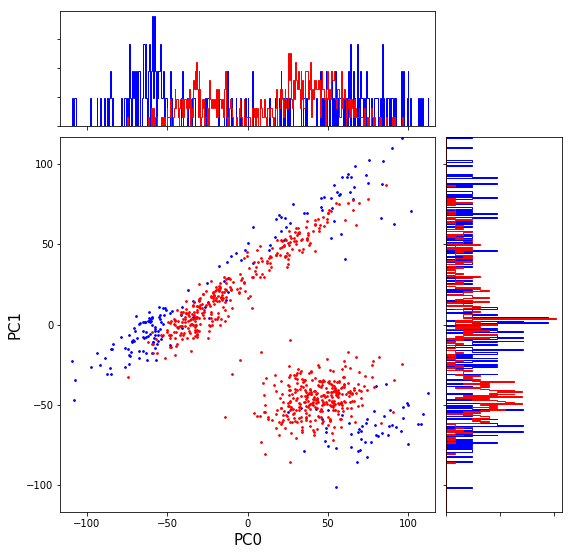

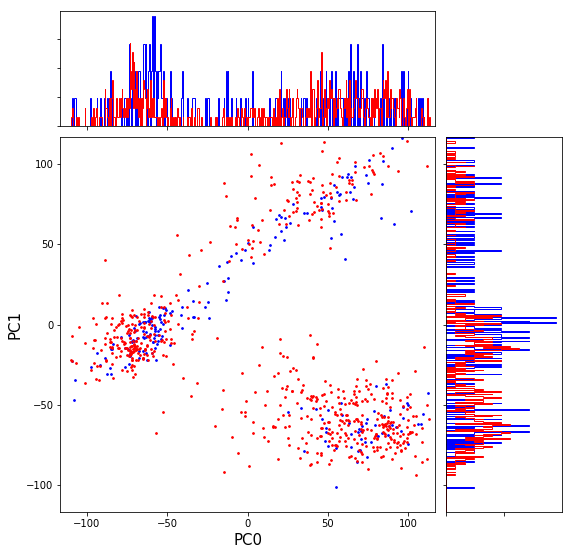

In [13]:
%matplotlib inline
calibratedSource = calibMMDNet.predict(source)

##################################### qualitative evaluation: PCA #####################################
pca = decomposition.PCA()
pca.fit(target)

# project data onto PCs
target_sample_pca = pca.transform(target)
projection_before = pca.transform(source)
projection_after = pca.transform(calibratedSource)

# choose PCs to plot
pc1 = 0
pc2 = 1
axis1 = 'PC'+str(pc1)
axis2 = 'PC'+str(pc2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_before[:,pc1], 
               projection_before[:,pc2], axis1, axis2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_after[:,pc1], 
               projection_after[:,pc2], axis1, axis2)

In [14]:
# df = pd.DataFrame(calibratedSource)
# df

In [15]:
# calibratedSourcePath = os.path.join(io.DeepLearningRoot(), 'data/calibratedBatch1-gtex-20PCs.csv')
# df.to_csv(calibratedSourcePath)